# CS421 Project
---

Group: Empirical Risk Minimisers  
Members:
- Lai Wan Xuan Joanne (joanne.lai.2021)
- Ryan Miguel Moralde Sia (ryansia.2022)
- Dhruv Benegal (benegalda.2022)
- Benedict Lee Zi Le (benedictlee.2022)

In this notebook, we train our models on the first batch of data provided, and produce predictions on the second batch of data.

### 1. Background & Objective

In this project, you will be working with data extracted from famous recommender systems type datasets: you are provided with a large set of interactions between users (persons) and items (movies). Whenever a user "interacts" with an item, it watches the movie and gives a "rating". There are 5 possible ratings expressed as a "number of stars": 1,2,3,4, or 5. 

In this exercise, we will **not** be performing the recommendation task per se. Instead, you will try to identify the amount of noise/corruption which was injected in each user. Indeed, for each of the users you have been given, an anomaly/noise generation procedure was applied to corrupt the sample. The noise generation procedure depends on two variables: the noise level $p\in [0,1]$ and the noise type $X\in\{0,1,2\}$.  Each user has been randomly assigned a noise level $p$ and anomaly/noise type $X$, and subsequently been corrupted with the associated noise generation procedure. 

You have two tasks: first, you must predict the noise level $p$ associated to each test user. This is a **supervised regression task**. Second, you must try to identify the noise generation type for each user. This is a classification task with three classes, with the possibility of including more classes later depending on class performance. This task will be semi-supervised: only a very small number of labels is provided. You will therefore need to combine supervised and unsupervised approaches for this component. 

### 2. Data

You are provided with three frames: the first one ("X") contains the interactions provided to you, and the second one ("yy") contains the continuous for the users. The third data frame "yy_cat" contains the anomaly/noise type for 15 users. The idea is to use these users to disambiguate the category types, but the task will mostly be unsupervised. 

As you can see, the three columns in "X" correspond to the user ID, the item ID and the rating (encoded into numerical form). Thus, each row of "X" contains a single interaction. For instance, if the row "$142, 152, 5$" is present, this means that the user with ID $142$ has given the movie $152$ a positive rating of $5$.

The dataframe "yy" has two columns. In the first column we have the user IDs, whilst the second column contains the continuous label. A label of $0.01$ indicates a very low anomaly level, whilst a label of $0.99$ indicates a very high amount of noise/corruption. 

### 3. Evaluation

Your task is to be able to regress the noise level $p$ for each new user, and predict the anomaly type $X$. The first (regression) task will be easier due to the larger amount of supervision, and will form the main basis of the evaluation. The second task will be more importance to showcase each team's creativity and differentiate between top performers. 

THE **EVALUATION METRICs** are:  

1. The Mean Absolute Error (MAE) for the regression task. 
2. The accuracy for the classiciation task. 

Every few weeks, we will evaluate the performance of each team (on a *test set with unseen labels* that I will provide) in terms of both metrics

The difficulty implied by **the generation procedure of the anomalies MAY CHANGE as the project evolves: depending on how well the teams are doing, I may generate easier or harder anomaly classes, which would change the number of labels in the classification task**. However, the regression task will still be the same (with a different distribution).

### 4. Deliverables

Together with this file, you are provided with a first batch of examples "`first_batch_regression_labelled.npz`" which are labelled in terms of noise level. You are also provided with the test samples to rank by the next round (without labels) in the file "`second_batch_regression_unlabelled.npz`".

The **first round** will take place after recess (week 9): you must hand in your scores for the second batch before the **Wednesday at NOON (15th of October)**. We will then look at the results together on the Friday.  

We will check everyone's performance in this way every week (once on  week 10, once on week 11 and once on week 12). 

---

To summarise, the project deliverables are as follows:

- Before every checkpoint's deadline, you need to submit **a `.csv` file** containing a dataframe of size $\text{number of test batch users} \times 3$.
    - The first column should be the user IDs of the test batch.
    - The second column should contain the estimated noise level $p$ for each sample.
    - The final column should contain the estimated class (it should be a natural number in \{0,1,2\}).
- The order of rows should correspond to the user IDs. For example, if the test batch contains users 1100-2200, scores for user 1100 should be the first row (row 0), scores for user 1101 should be the second row (row 1), and so on.
- On Week 12-13 (schedule to be decided), you need to present your work in class. The presentation duration is **10 minutes** with 5 minutes of QA.
- On Week 12, you need to submit your **Jupyter Notebook** (with comments in Markdown) and the **slides** for your presentation. 
- On week 13 you need to submit your **final report**. The final report should be 2-3 pages long (consisting of problem statement, literature review, and motivation of algorithm design) with unlimited references/appendix.

Whilst performance (expressed in terms of MAE and accuracy) at **each of the check points** (weeks 9 to 12 inclusive) is an **important component** of your **final grade**, the **final report** and the detail of the various methods you will have tried will **also** be very **important**. Ideally, to get perfect marks (A+), you should try at least **two supervised methods** and **two unsupervised methods**, as well as be ranked the **best team** in terms of performance. 


In addition, I will be especially interested in your **reasoning**. Especially high marks will be awarded to any team that is able to **qualitatively describe** the difference between the two anomaly types. You are also encouraged to compute statistics related to each class and describe what is different about them. 

## Imports

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis
from sklearn.decomposition import PCA
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    Ridge,
    Lasso,
    SGDRegressor
    )
from sklearn.tree import (
    DecisionTreeRegressor
)
from sklearn.ensemble import (
    RandomForestRegressor,
    BaggingRegressor
)
from sklearn.metrics import (
    mean_absolute_error,
    accuracy_score
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold
)
from sklearn.cluster import KMeans
from sklearn.ensemble import StackingRegressor
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping

%matplotlib inline

## Data Loading and Cleaning

### Data Loading

In [19]:
# Load the data
first_batch  = np.load("data/Week1/first_batch_regression_labelled.npz")
second_batch  = np.load("data/Week2/second_batch_regression_labelled.npz")

# Extract X, y, y_cat for each batch
X1, y1, y1_cat = first_batch["X"], first_batch["yy"], first_batch["yy_cat"]
X2, y2, y2_cat = second_batch["X"], second_batch["yy"], second_batch["yy_cat"]

# Convert to DataFrames and rename columns for each batch
X1     = pd.DataFrame(X1, columns=["user", "item", "rating"])
y1     = pd.DataFrame(y1, columns=["user", "label"])
y1_cat = pd.DataFrame(y1_cat, columns=["user", "label", "anomtype"])
X2     = pd.DataFrame(X2, columns=["user", "item", "rating"])
y2     = pd.DataFrame(y2, columns=["user", "label"])
y2_cat = pd.DataFrame(y2_cat, columns=["user", "label", "anomtype"])

# Combine the data 
X = pd.concat([X1, X2], ignore_index=True)
y = pd.concat([y1, y2], ignore_index=True)
y_cat = pd.concat([y1_cat, y2_cat], ignore_index=True)

# Parse to correct types
y     = y.astype({"user": int, "label": float})
y_cat = y_cat.astype({"user": int, "label": float, "anomtype": int})

In [20]:
XX    = np.load("data/Week2/third_batch_regression_unlabelled.npz")['X']
XX    = pd.DataFrame(XX, columns=["user", "item", "rating"])

In [21]:
# X contains interactions provided
# has 570651 rows

X

,user,item,rating
0,0,94,2
1,0,90,1
2,0,97,2
3,0,100,4
4,0,101,2
...,...,...,...
570646,1799,319,4
570647,1799,318,5
570648,1799,316,3
570649,1799,814,4


In [22]:
# y contains the noise level p
# Has 1800 rows corresponding to users

y

print("---To check if number of users in X corresponds to number of rows in y---")
print(f"Number of unique users in X: {X['user'].nunique()}")
print(f"Number of rows in y: {len(y)}")

---To check if number of users in X corresponds to number of rows in y---
Number of unique users in X: 1800
Number of rows in y: 1800


In [23]:
# y_cat contains the anomaly/noise type, which is in {0, 1, 2}
# Only has 30 rows

y_cat

,user,label,anomtype
0,561,0.383316,1
1,202,0.925028,2
2,205,0.380860,2
3,424,0.255181,1
4,284,0.055162,2
5,667,0.558745,0
6,730,0.311928,1
7,469,0.233492,2
8,199,0.165112,1
9,699,0.261752,2


In [24]:
# XX contains the second batch of data that we predict anomaly and noise on

XX

,user,item,rating
0,1800,594,2
1,1800,371,4
2,1800,365,4
3,1800,362,4
4,1800,359,4
...,...,...,...
286896,2699,295,1
286897,2699,280,3
286898,2699,542,0
286899,2699,870,0


### Feature Engineering
For further explanation on how we decided on these features, refer to file `EDA.ipynb`.

In [25]:
# Define the engineer_features function to add additional features

def engineer_features(df_X, df_y=None):
    df_X_no_dupes = df_X.drop_duplicates(subset=["user", "item"], keep="last")
    df_ratings = df_X_no_dupes.pivot(index='user', columns='item', values='rating').fillna(-1)
    all_items = range(0, 1000)
    df_ratings = df_ratings.reindex(columns=all_items, fill_value=-1)

    # Basic user features
    df_user_features = df_X.groupby("user").agg(
        mean_rating=("rating", "mean"),
        median_rating=("rating", "median"),
        std_rating=("rating", "std"),
        count_dislike=("rating", lambda x: ((x == 0) | (x == 1) | (x == 2)).sum()),
        count_neutral=("rating", lambda x: (x == 3).sum()),
        count_like=("rating", lambda x: ((x == 4) | (x == 5)).sum()),
        total_interactions=("rating", "count"),
    )

    # Ratio features
    df_user_features["like_ratio"] = (
        df_user_features["count_like"] / df_user_features["total_interactions"]
    )
    df_user_features["dislike_ratio"] = (
        df_user_features["count_dislike"] / df_user_features["total_interactions"]
    )
    df_user_features["neutral_ratio"] = (
        df_user_features["count_neutral"] / df_user_features["total_interactions"]
    )

    # Weighted scores
    df_user_features["weighted_score"] = (
        df_user_features["count_like"] * 1.5 - df_user_features["count_dislike"] * 1.5
    )

    # Distribution features
    df_user_features["rating_kurtosis"] = df_X.groupby("user")["rating"].apply(
        lambda x: kurtosis(x)
    )

    # Fill NaN values in std_rating and rating_kurtosis
    df_user_features["std_rating"] = df_user_features["std_rating"].fillna(0)
    df_user_features["rating_kurtosis"] = df_user_features["rating_kurtosis"].fillna(0)

    final_df = pd.merge(df_ratings.reset_index(), df_user_features, on='user')
    
    if df_y is not None:
        df_merged = pd.merge(final_df.reset_index(), df_y, on="user", how="inner")
        return df_merged.drop(columns=["index"]).set_index("user")
    else:
        return final_df.set_index("user")

## Evaluation Functions

In [26]:
# To print MAE for regression task
def evaluate_linear_predictions(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Test MAE: {mae:.4f}")

# To print accuracy for classification task
def evaluate_classification_accuracy(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")
    return accuracy

## Regression Task

### Feature Engineering

In [27]:
# Create the initial dataframe for linear regression, using X and y
df_reg = engineer_features(X, y)
df_reg.columns = df_reg.columns.astype(str)

display(df_reg.head())

,0,1,2,3,4,5,6,7,8,9,...,count_dislike,count_neutral,count_like,total_interactions,like_ratio,dislike_ratio,neutral_ratio,weighted_score,rating_kurtosis,label
user,,,,,,,,,,,,,,,,,,,,,
0,4.0,-1.0,-1.0,-1.0,4.0,-1.0,-1.0,-1.0,-1.0,4.0,...,108,45,49,202,0.242574,0.534653,0.222772,-88.5,-1.329120,0.962817
1,-1.0,-1.0,2.0,3.0,-1.0,2.0,-1.0,-1.0,3.0,-1.0,...,138,154,43,335,0.128358,0.411940,0.459701,-142.5,0.483190,0.031248
2,4.0,-1.0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1,54,207,262,0.790076,0.003817,0.206107,309.0,0.281598,0.068668
3,4.0,2.0,4.0,-1.0,1.0,3.0,-1.0,3.0,5.0,4.0,...,36,53,213,302,0.705298,0.119205,0.175497,265.5,1.077512,0.349012
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,-1.0,-1.0,...,7,6,329,342,0.961988,0.020468,0.017544,483.0,2.194315,0.917704


In [28]:
# Prepare and split dataset into train and validation set

# Step 1: Extract features and labels
X_lr = df_reg.drop(columns=["label"]).values # Features
y_lr = df_reg["label"].values # Labels

# Step 2: Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_lr, y_lr, test_size = 0.2, random_state=421
)

print("Shapes (regression):")
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

Shapes (regression):
(1440, 1012) (1440,) (360, 1012) (360,)


In [29]:
# Standardise features (for regression)

scaler_reg = StandardScaler().fit(X_train)
X_train_std = scaler_reg.transform(X_train)
X_val_std = scaler_reg.transform(X_val)

### Linear-based models (Linear Regression, Ridge, Lasso)

In [30]:
# Linear Regression

lr = LinearRegression()
lr.fit(X_train_std, y_train)

y_pred = lr.predict(X_val_std)
y_test = lr.predict(X_train_std)

print("Actual result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set:")
evaluate_linear_predictions(y_train, y_test)

Actual result:
Test MAE: 0.2588
Result on training set:
Test MAE: 0.0763


In [31]:
# Ridge Regression

ridge = Ridge(alpha=1)
ridge.fit(X_train_std, y_train)
y_pred = ridge.predict(X_val_std)
y_test = ridge.predict(X_train_std)

print("Actual result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set:")
evaluate_linear_predictions(y_train, y_test)

Actual result:
Test MAE: 0.2558
Result on training set:
Test MAE: 0.0763


In [32]:
# Lasso Regression

lasso = Lasso(alpha=1)
lasso.fit(X_train_std, y_train)
y_pred = lasso.predict(X_val_std)
y_test = lasso.predict(X_train_std)

print("Actual result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

Actual result:
Test MAE: 0.2500
Result on training set (test for overfitting):
Test MAE: 0.2513


In [33]:
# Stochastic Gradient Descent (SGD) Regression

sgd = SGDRegressor()
sgd.fit(X_train_std, y_train)
y_pred = sgd.predict(X_val_std)
y_test = sgd.predict(X_train_std)

print("Actual result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

Actual result:
Test MAE: 0.3114
Result on training set (test for overfitting):
Test MAE: 0.1051


It appears that all linear-based models do not perform very well, which is expected as the data is not likely to follow a linear distribution.  
We thus attempt using other models.

### Tree-based models (DecisionTree, XGBRegressor)

In [34]:
# Decision Tree

dtr = DecisionTreeRegressor()
dtr.fit(X_train_std, y_train)
y_pred = dtr.predict(X_val_std)
y_test = dtr.predict(X_train_std)

print("Actual result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

Actual result:
Test MAE: 0.1567
Result on training set (test for overfitting):
Test MAE: 0.0000


In [35]:
# XGB Regressor 
# XGB is an optimised software library that uses gradient boosted decision trees
# We first try it without tweaking parameters

xgbr = XGBRegressor()
xgbr.fit(X_train_std, y_train)
y_pred = xgbr.predict(X_val_std)
y_test = xgbr.predict(X_train_std)

print("Actual result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

Actual result:
Test MAE: 0.1014
Result on training set (test for overfitting):
Test MAE: 0.0004


In [36]:
# This code made my potato laptop crank up its fans to the max, but not much diff
# I did use the parameters in there and got a slight MAE improvement though

# from sklearn.model_selection import RandomizedSearchCV

# xgbr = XGBRegressor(
#     random_state=1024,
#     eval_metric="mae",
#     n_jobs=-1
# )

# param_dist = {
#     "n_estimators": [300, 500, 800, 1000],
#     "max_depth": [3, 4, 5, 6],
#     "learning_rate": [0.01, 0.05, 0.1],
#     "subsample": [0.7, 0.8, 1.0],
#     "colsample_bytree": [0.7, 0.8, 1.0],
#     "reg_lambda": [0.5, 1.0, 2.0, 5.0],
#     "min_child_weight": [1, 3, 5]
# }

# search = RandomizedSearchCV(
#     estimator=xgbr,
#     param_distributions=param_dist,
#     n_iter=30,
#     scoring="neg_mean_absolute_error",
#     cv=3,
#     verbose=1,
#     n_jobs=-1,
#     random_state=1024
# )

# # Combining both train and val, because RandomisedSearchCV internally breaks into folds to train the model
# X_train_xgbr = np.concatenate((X_train_std, X_val_std), axis=0)
# y_train_xgbr = np.concatenate((y_train, y_val), axis=0)
# search.fit(X_train_xgbr, y_train_xgbr)

# print("Best MAE:", -search.best_score_)
# print("Best Parameters:", search.best_params_)

In [37]:
# XGB Regressor
# We now try tweaking the parameters to improve MAE

xgbr = XGBRegressor(
    random_state=421,
    n_estimators=1000, # total number of trees
    learning_rate=0.05, # step size
    max_depth=4, # controls model complexity, prevents overfitting.
    subsample=0.7, # sample 70% of training data per tree
    colsample_bytree=0.8, # sample 80% of features per tree
    reg_lambda=1.0, # L2 regularization term
    n_jobs=-1,
    eval_metric="mae",
    callbacks=[EarlyStopping(
        rounds=50, # stop if no improvement for 50 rounds
        metric_name="mae",
        save_best=True # keep the best model iteration
    )]
)

xgbr.fit(
    X_train_std, y_train,
    eval_set=[(X_val_std, y_val)],
    verbose=False,
)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,[<xgboost.call...001515C5EA270>]
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mae'


In [38]:
print("Best iteration:", xgbr.best_iteration)
print("Best MAE:", xgbr.best_score)

y_pred = xgbr.predict(X_val_std)
y_test = xgbr.predict(X_train_std)

print("Actual result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

Best iteration: 859
Best MAE: 0.08300342362167107
Actual result:
Test MAE: 0.0830
Result on training set (test for overfitting):
Test MAE: 0.0038


In [39]:
# LightGBM Regressor

lgbm = LGBMRegressor(
    random_state=421,
    max_depth=4,
    num_leaves=25,
    n_estimators=2000,
    learning_rate=0.01,
    reg_alpha=0.1,
    reg_lambda=1.0,
    subsample=0.8,
    colsample_bytree=0.7,
)

lgbm.fit(X_train_std, y_train)
y_pred = lgbm.predict(X_val_std)
y_test = lgbm.predict(X_train_std)

print("Actual result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10534
[LightGBM] [Info] Number of data points in the train set: 1440, number of used features: 1012
[LightGBM] [Info] Start training from score 0.500502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

c:\Users\Ben\anaconda3\envs\cs421\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
c:\Users\Ben\anaconda3\envs\cs421\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [40]:
# CatBoostRegressor

cbr = CatBoostRegressor(
    random_state=421,
    loss_function='MAE',
    learning_rate=0.01,
    depth=4,
    l2_leaf_reg=5,
)

cbr.fit(X_train_std, y_train)
y_pred = cbr.predict(X_val_std)
y_test = cbr.predict(X_train_std)

print("Actual result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

0:	learn: 0.2499322	total: 158ms	remaining: 2m 38s
1:	learn: 0.2484109	total: 172ms	remaining: 1m 25s
2:	learn: 0.2468577	total: 177ms	remaining: 58.7s
3:	learn: 0.2454961	total: 182ms	remaining: 45.4s
4:	learn: 0.2440236	total: 187ms	remaining: 37.3s
5:	learn: 0.2426824	total: 192ms	remaining: 31.8s
6:	learn: 0.2412659	total: 197ms	remaining: 27.9s
7:	learn: 0.2397327	total: 203ms	remaining: 25.2s
8:	learn: 0.2383554	total: 208ms	remaining: 22.9s
9:	learn: 0.2369057	total: 213ms	remaining: 21.1s
10:	learn: 0.2356300	total: 218ms	remaining: 19.6s
11:	learn: 0.2342711	total: 224ms	remaining: 18.4s
12:	learn: 0.2329272	total: 229ms	remaining: 17.4s
13:	learn: 0.2315814	total: 234ms	remaining: 16.5s
14:	learn: 0.2303387	total: 239ms	remaining: 15.7s
15:	learn: 0.2290471	total: 244ms	remaining: 15s
16:	learn: 0.2280953	total: 249ms	remaining: 14.4s
17:	learn: 0.2268017	total: 253ms	remaining: 13.8s
18:	learn: 0.2256943	total: 258ms	remaining: 13.3s
19:	learn: 0.2244570	total: 263ms	remaini

We find that Tree-based models perform much better than Linear-based models, which is understandable as the data likely does not follow a linear distribution.  
In particular, the XGB Regressor gives an exceptionally good performance (MAE = 0.0830).

### Ensemble-based models (RandomForest, BaggingRegressor)

In [41]:
# Random Forest
rfr = RandomForestRegressor(random_state=421)
rfr.fit(X_train_std, y_train)
y_pred = rfr.predict(X_val_std)
y_test = rfr.predict(X_train_std)

print("Actual result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

Actual result:
Test MAE: 0.1025
Result on training set (test for overfitting):
Test MAE: 0.0377


In [42]:
# Bagging

br = BaggingRegressor(random_state=421)
br.fit(X_train_std, y_train)
y_pred = br.predict(X_val_std)
y_test = br.predict(X_train_std)

print("Actual result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

Actual result:
Test MAE: 0.1146
Result on training set (test for overfitting):
Test MAE: 0.0460


Ensemble-based methods also provide good performance out-of-the-box, but we find that Tree-based regressors provide the best performance out of all the supervised learning methods.

### Neural Network models

In [43]:
mlp = MLPRegressor(
    hidden_layer_sizes=(256, 128, 64, 32),
    activation='relu',
    solver='adam',
    alpha=0.01,
    learning_rate_init=0.005,
    max_iter=2000,
    random_state=421
)

mlp.fit(X_train_std, y_train)
y_pred = mlp.predict(X_val_std)
y_test = mlp.predict(X_train_std)

print("Actual result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

Actual result:
Test MAE: 0.1098
Result on training set (test for overfitting):
Test MAE: 0.0222


After some fine tuning, the MLP Regressor is able to get quite good performance on the validation dataset, comparable with both tree-based and ensemble-based methods.

### Unsupervised models

In [44]:
# Trying out PCA + XGBRegressor

pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_std)
X_val_pca = pca.transform(X_val)

xgbr2 = XGBRegressor(
    random_state=421,
    n_estimators=1000, # total number of trees
    learning_rate=0.05, # step size
    max_depth=4, # controls model complexity, prevents overfitting.
    subsample=0.7, # sample 70% of training data per tree
    colsample_bytree=0.8, # sample 80% of features per tree
    reg_lambda=1.0, # L2 regularization term
    n_jobs=-1,
    eval_metric="mae",
    callbacks=[EarlyStopping(
        rounds=50, # stop if no improvement for 50 rounds
        metric_name="mae",
        save_best=True # keep the best model iteration
    )]
)

xgbr2.fit(
    X_train_pca, y_train,
    eval_set=[(X_val_pca, y_val)],
    verbose=False,
)

y_pred = xgbr2.predict(X_val_pca)
y_test = xgbr2.predict(X_train_pca)

print("Actual result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

Actual result:
Test MAE: 0.2058
Result on training set (test for overfitting):
Test MAE: 0.1029


Reducing the dimensionality of the data does not seem to work very well overall, even when we vary the number of components.

### Combining the different models together

In [45]:
# We check the correlations between the predictions of the best models
# If the models are too closely related, there is no point in stacking them

pred_xgb = xgbr.predict(X_val_std)
pred_lgbm = lgbm.predict(X_val_std)
pred_cbr = cbr.predict(X_val_std)
pred_rf = rfr.predict(X_val_std)
pred_mlp = mlp.predict(X_val_std)

corr_matrix = np.corrcoef([pred_xgb, pred_lgbm, pred_cbr, pred_rf, pred_mlp])
print(corr_matrix)

c:\Users\Ben\anaconda3\envs\cs421\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[[1.         0.99035959 0.97489721 0.9721938  0.89727721]
 [0.99035959 1.         0.98291781 0.97836069 0.89127056]
 [0.97489721 0.98291781 1.         0.97593318 0.88716402]
 [0.9721938  0.97836069 0.97593318 1.         0.86058188]
 [0.89727721 0.89127056 0.88716402 0.86058188 1.        ]]


In [46]:
# We stack the two best performing models that are not strongly correlated (corr < 0.95)
# This can potentially improve our performance, as the MLP can capture smooth nonlinear patterns missed by tree models
# The stacking regressor can combine these predictions to reduce both bias and variance, improving overall MAE

stack = StackingRegressor(
    estimators=[
        ("xgb", XGBRegressor(
            random_state=421,
            n_estimators=1000,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.7, 
            colsample_bytree=0.8, 
            reg_lambda=1.0,
            n_jobs=-1,
            eval_metric="mae",
        )),
        ("mlp", MLPRegressor(
            hidden_layer_sizes=(256, 128, 64, 32),
            activation='relu',
            solver='adam',
            alpha=0.01,
            learning_rate_init=0.005,
            max_iter=2000,
            random_state=421
        ))
    ],
    final_estimator=Ridge(alpha=0.1)
)

stack.fit(X_train_std, y_train)
y_pred = stack.predict(X_val_std)
y_test = stack.predict(X_train_std)

print("Actual result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

Actual result:
Test MAE: 0.0809
Result on training set (test for overfitting):
Test MAE: 0.0153


Our hypothesis that stacking the two regressors increases performance proves true.  
We thus then train this model on the full dataset, to prepare it to predict on the third batch.

### Preparing final regression model

In [47]:
# Training final model on full dataset

scaler_full = StandardScaler()
X_all_std = scaler_full.fit_transform(X_lr)

stack.fit(X_all_std, y_lr)

,estimators,"[('xgb', ...), ('mlp', ...)]"
,final_estimator,Ridge(alpha=0.1)
,cv,None
,n_jobs,None
,passthrough,False
,verbose,0
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None


## Classification Task

### Feature Engineering

In [48]:
# Combine dataframe with anomtype: use y_cat instead of y

df_cla = engineer_features(X, y_cat)

# We convert all column names to strings so it does not throw an error later
df_cla.columns = df_cla.columns.astype(str)
display(df_cla)
df_cla["anomtype"].value_counts()

,0,1,2,3,4,5,6,7,8,9,...,count_neutral,count_like,total_interactions,like_ratio,dislike_ratio,neutral_ratio,weighted_score,rating_kurtosis,label,anomtype
user,,,,,,,,,,,,,,,,,,,,,
26,2.0,-1.0,-1.0,4.0,3.0,-1.0,4.0,4.0,4.0,-1.0,...,60,98,244,0.401639,0.352459,0.245902,18.0,-0.604327,0.558222,0
199,5.0,-1.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,5.0,-1.0,...,83,95,211,0.450237,0.156398,0.393365,93.0,0.710936,0.165112,1
202,5.0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1,212,214,0.990654,0.004673,0.004673,316.5,0.128747,0.925028,2
205,2.0,3.0,2.0,1.0,-1.0,-1.0,-1.0,4.0,4.0,-1.0,...,97,220,367,0.599455,0.136240,0.264305,255.0,0.032162,0.380860,2
231,3.0,-1.0,4.0,3.0,-1.0,1.0,1.0,-1.0,2.0,1.0,...,94,82,358,0.229050,0.508380,0.262570,-150.0,-1.347485,0.951103,0
284,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,-1.0,...,23,199,223,0.892377,0.004484,0.103139,297.0,0.534990,0.055162,2
424,4.0,1.0,-1.0,-1.0,-1.0,3.0,-1.0,-1.0,4.0,4.0,...,73,93,200,0.465000,0.170000,0.365000,88.5,-0.210772,0.255181,1
459,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,-1.0,...,57,82,230,0.356522,0.395652,0.247826,-13.5,-1.203525,0.739300,0
469,4.0,-1.0,3.0,3.0,-1.0,3.0,-1.0,-1.0,3.0,4.0,...,111,124,269,0.460967,0.126394,0.412639,135.0,0.029708,0.233492,2


anomtype
0    10
1    10
2    10
Name: count, dtype: int64

In [49]:
# Separate the dataframes into input X and label y

X_log = df_cla.drop(columns=["label", "anomtype"])
y_log = df_cla["anomtype"]

display(X_log)
display(y_log)

,0,1,2,3,4,5,6,7,8,9,...,std_rating,count_dislike,count_neutral,count_like,total_interactions,like_ratio,dislike_ratio,neutral_ratio,weighted_score,rating_kurtosis
user,,,,,,,,,,,,,,,,,,,,,
26,2.0,-1.0,-1.0,4.0,3.0,-1.0,4.0,4.0,4.0,-1.0,...,1.185510,86,60,98,244,0.401639,0.352459,0.245902,18.0,-0.604327
199,5.0,-1.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,5.0,-1.0,...,1.104391,33,83,95,211,0.450237,0.156398,0.393365,93.0,0.710936
202,5.0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.535682,1,1,212,214,0.990654,0.004673,0.004673,316.5,0.128747
205,2.0,3.0,2.0,1.0,-1.0,-1.0,-1.0,4.0,4.0,-1.0,...,1.031393,50,97,220,367,0.599455,0.136240,0.264305,255.0,0.032162
231,3.0,-1.0,4.0,3.0,-1.0,1.0,1.0,-1.0,2.0,1.0,...,1.113685,182,94,82,358,0.229050,0.508380,0.262570,-150.0,-1.347485
284,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,-1.0,...,0.575072,1,23,199,223,0.892377,0.004484,0.103139,297.0,0.534990
424,4.0,1.0,-1.0,-1.0,-1.0,3.0,-1.0,-1.0,4.0,4.0,...,0.868835,34,73,93,200,0.465000,0.170000,0.365000,88.5,-0.210772
459,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,-1.0,...,1.216930,91,57,82,230,0.356522,0.395652,0.247826,-13.5,-1.203525
469,4.0,-1.0,3.0,3.0,-1.0,3.0,-1.0,-1.0,3.0,4.0,...,0.925767,34,111,124,269,0.460967,0.126394,0.412639,135.0,0.029708


user
26      0
199     1
202     2
205     2
231     0
284     2
424     1
459     0
469     2
561     1
667     0
699     2
730     1
786     0
849     1
1045    2
1057    0
1066    2
1151    1
1279    0
1289    2
1307    1
1450    0
1455    1
1561    1
1563    2
1617    0
1640    0
1682    2
1722    1
Name: anomtype, dtype: int64

In [50]:
# Scale features in X

scaler_cla = StandardScaler().fit(X_log)
X_log_std = scaler_cla.transform(X_log)

### Logistic Regression

In [51]:
# Logistic Regression

# log_reg = LogisticRegression(
#     penalty="l2", # ridge regression
#     C=0.01,
#     solver="liblinear", # efficient for small-medium datasets
#     max_iter=1000
# )

log_reg = LogisticRegression(
    penalty="elasticnet",
    l1_ratio=0.5,
    C=0.01,
    solver="saga",
    max_iter=10000
)

# Wrap log_reg in OneVsRest classifier so the solver works for our multiclass classifier
log_classifier = OneVsRestClassifier(log_reg)

# Using StratifiedKFold, for n_splits=5, we train on 4 folds and validate on the remaining fold
# then compute accuracy based on that fold
cv = StratifiedKFold(n_splits=5)

# Code for GridSearchCV: to find the best value of C
param_grid = {
    'estimator__C': [0.1, 1, 10], 
    'estimator__l1_ratio': [0.25, 0.5, 0.75]}
grid = GridSearchCV(
    estimator=log_classifier,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy'
)

grid.fit(X_log_std, y_log)

print("Best C:", grid.best_params_)
print("Best CV Accuracy: %.4f" % grid.best_score_)

cv_results = pd.DataFrame(grid.cv_results_)
display(cv_results[[
    'param_estimator__C', 
    'param_estimator__l1_ratio', 
    'mean_test_score', 
    'std_test_score']])

Best C: {'estimator__C': 10, 'estimator__l1_ratio': 0.25}
Best CV Accuracy: 0.7333


,param_estimator__C,param_estimator__l1_ratio,mean_test_score,std_test_score
0,0.1,0.25,0.633333,0.163299
1,0.1,0.50,0.500000,0.182574
2,0.1,0.75,0.333333,0.000000
3,1.0,0.25,0.600000,0.169967
4,1.0,0.50,0.666667,0.149071
5,1.0,0.75,0.633333,0.163299
6,10.0,0.25,0.733333,0.169967
7,10.0,0.50,0.733333,0.169967
8,10.0,0.75,0.700000,0.124722


In [52]:
# To get final logistic regression model, we choose the best value of C

log_reg = LogisticRegression(
    penalty="elasticnet",
    C=grid.best_params_['estimator__C'],
    l1_ratio=grid.best_params_['estimator__l1_ratio'],
    solver="saga",
    max_iter=10000
)

log_classifier = OneVsRestClassifier(log_reg)

final_model = log_classifier.fit(X_log_std, y_log)
final_model

,estimator,LogisticRegre...solver='saga')
,n_jobs,None
,verbose,0
,penalty,'elasticnet'
,dual,False
,tol,0.0001
,C,10
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None


We are able to get an overall accuracy of 73% using this Logistic Regression model trained on ElasticNet, which is quite decent.  
We move on to see if unsupervised methods can help us attain a higher accuracy.

### Unsupervised methods (KMeans)

In [53]:
# We try and cluster users just based off the created features
# Create a dataframe without noise level nor anomtype

df_cla_2 = engineer_features(X)
df_cla_2 = df_cla_2[[
    "mean_rating",
    "median_rating",
    "std_rating",
    "count_dislike",
    "count_neutral",
    "count_like",
    "total_interactions",
    "like_ratio",
    "dislike_ratio",
    "neutral_ratio",
    "weighted_score",
    "rating_kurtosis"
]]

# We convert all column names to strings so it does not throw an error later
df_cla_2.columns = df_cla_2.columns.astype(str)
df_cla_2.head()

,mean_rating,median_rating,std_rating,count_dislike,count_neutral,count_like,total_interactions,like_ratio,dislike_ratio,neutral_ratio,weighted_score,rating_kurtosis
user,,,,,,,,,,,,
0,2.435644,2.0,1.145320,108,45,49,202,0.242574,0.534653,0.222772,-88.5,-1.329120
1,2.698507,3.0,0.838000,138,154,43,335,0.128358,0.411940,0.459701,-142.5,0.483190
2,3.904580,4.0,0.576070,1,54,207,262,0.790076,0.003817,0.206107,309.0,0.281598
3,3.801325,4.0,1.081526,36,53,213,302,0.705298,0.119205,0.175497,265.5,1.077512
4,4.409357,4.0,0.633128,7,6,329,342,0.961988,0.020468,0.017544,483.0,2.194315


In [54]:
# Scale the features for KMeans (separate scaler for separate dataframe)

scaler_kmeans = StandardScaler()
df_cla_2_scaled = scaler_kmeans.fit_transform(df_cla_2)
df_cla_2_scaled

array([[-1.62167835, -2.38710963,  0.76627348, ..., -0.37419991,
        -1.2275996 , -1.05030293],
       [-1.17194931, -0.74554427, -0.63286158, ...,  1.40505243,
        -1.51350858,  0.18034337],
       [ 0.89149843,  0.89602109, -1.82534702, ..., -0.49935106,
         0.87700813,  0.04345258],
       ...,
       [ 1.38376622,  0.89602109, -0.29431272, ..., -1.46947442,
         0.60698299,  3.69947602],
       [ 1.3795012 ,  0.89602109, -0.33805277, ..., -1.8733046 ,
         0.6625764 ,  2.10277801],
       [ 0.53430746,  0.89602109,  0.06887243, ...,  0.13223132,
         0.3131321 , -0.51573165]], shape=(1800, 12))

In [55]:
# Bring the features back into a dataframe

X_kmeans = pd.DataFrame(
    df_cla_2_scaled,
    columns=df_cla_2.columns,
    index=df_cla_2.index
)
X_kmeans

,mean_rating,median_rating,std_rating,count_dislike,count_neutral,count_like,total_interactions,like_ratio,dislike_ratio,neutral_ratio,weighted_score,rating_kurtosis
user,,,,,,,,,,,,
0,-1.621678,-2.387110,0.766273,0.661236,-0.749121,-1.289002,-1.072691,-1.206625,2.054980,-0.374200,-1.227600,-1.050303
1,-1.171949,-0.745544,-0.632862,1.144034,1.166220,-1.357153,0.167594,-1.701441,1.286976,1.405052,-1.513509,0.180343
2,0.891498,0.896021,-1.825347,-1.060742,-0.590973,0.505626,-0.513164,1.165308,-1.267276,-0.499351,0.877008,0.043453
3,0.714840,0.896021,0.475840,-0.497478,-0.608545,0.573776,-0.140146,0.798025,-0.545114,-0.729222,0.646693,0.583917
4,1.755111,0.896021,-1.565580,-0.964183,-1.434426,1.891351,0.232872,1.910079,-1.163065,-1.915391,1.798270,1.342281
...,...,...,...,...,...,...,...,...,...,...,...,...
1795,-0.860503,-0.745544,-0.506897,0.532490,0.656634,-1.073193,-0.224075,-1.252081,0.844853,1.156631,-1.013168,-0.086002
1796,-1.144955,-0.745544,0.818756,0.983101,0.094332,-0.857383,-0.084193,-1.033796,1.309783,0.220381,-1.084645,-0.783828
1797,1.383766,0.896021,-0.294313,-0.915903,-1.258707,0.221666,-1.016738,1.533222,-0.990273,-1.469474,0.606983,3.699476


In [56]:
# Apply KMeans to sort the users into diffent clusters

kmeans = KMeans(n_clusters=3, random_state=421)
X_kmeans["cluster"] = kmeans.fit_predict(X_kmeans)
X_kmeans["cluster"]

user
0       0
1       0
2       1
3       1
4       1
       ..
1795    0
1796    0
1797    1
1798    1
1799    2
Name: cluster, Length: 1800, dtype: int32

In [57]:
# Merge with y_cat to check the difference between the predicted clusters and actual anomtype

merged_df = pd.merge(X_kmeans, y_cat, on="user", how="inner")
merged_df = merged_df[["user", "cluster", "anomtype"]]
display(merged_df)

,user,cluster,anomtype
0,26,0,0
1,199,2,1
2,202,1,2
3,205,2,2
4,231,0,0
5,284,1,2
6,424,2,1
7,459,0,0
8,469,2,2
9,561,2,1


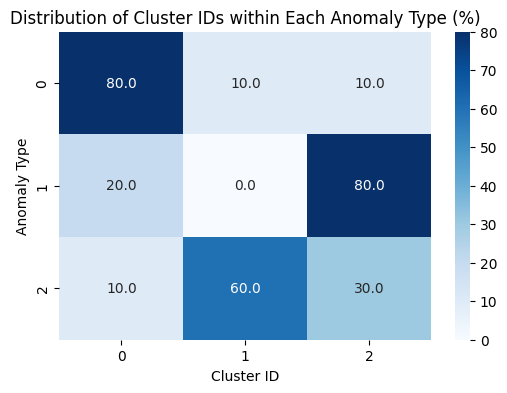

In [58]:
# Create heatmap for easy visualisation

ct = pd.crosstab(merged_df["anomtype"], merged_df["cluster"], normalize='index') * 100
plt.figure(figsize=(6,4))
sns.heatmap(ct, annot=True, cmap="Blues", fmt=".1f")
plt.title("Distribution of Cluster IDs within Each Anomaly Type (%)")
plt.ylabel("Anomaly Type")
plt.xlabel("Cluster ID")
plt.show()

From this heatmap, we see that the best possible accuracy we can achieve is 73%, if we do the following mapping:
- Cluster ID 0 to anomaly type 1
- Cluster ID 1 to anomaly type 2
- Cluster ID 2 to anomaly type 0.  

This is equivalent to the accuracy obtained from logistic regression (73%).

Lastly, we try using PCA in addition to KMeans to see if it improves our performance.  

### Unsupervised Methods (PCA + KMeans)

In [59]:
# Apply PCA to reduce features to 3 dimensions
pca = PCA(n_components=3)
X_pca = pca.fit_transform(df_cla_2_scaled)

# Train KMeans on PCA-transformed features
pca_kmeans = KMeans(n_clusters=3, random_state=69)
pca_clusters = pca_kmeans.fit_predict(X_pca)

# Save clusters from numpy array into a dataframe
df_pca_kmeans = pd.DataFrame(X_pca, index=df_cla_2.index, columns=[
    "PC1", "PC2", "PC3"
    ])
df_pca_kmeans["cluster"] = pca_clusters

df_pca_kmeans

,PC1,PC2,PC3,cluster
user,,,,
0,-3.689013,-2.178458,-0.262588,1
1,-3.393152,0.797950,1.141439,1
2,2.923078,-0.062928,0.972592,2
3,1.918497,-0.492141,-0.618124,2
4,4.899018,0.004098,-0.974646,2
...,...,...,...,...
1795,-2.435504,0.274056,1.193617,1
1796,-2.866617,-0.648165,-0.401243,1
1797,3.876187,-1.262620,0.004901,2


In [60]:
# Check how clusters align with true anomaly types

pca_merged = pd.merge(df_pca_kmeans, y_cat, on="user", how="inner")
pca_merged

,user,PC1,PC2,PC3,cluster,label,anomtype
0,26,-1.755112,-1.420219,-0.279300,1,0.558222,0
1,199,-0.584089,-0.697165,1.258348,0,0.165112,1
2,202,4.175913,-1.319253,0.212820,2,0.925028,2
3,205,1.085268,0.561885,-0.420970,0,0.380860,2
4,231,-4.287866,-0.473101,-1.051406,1,0.951103,0
5,284,3.503875,-0.877177,0.643910,2,0.055162,2
6,424,-0.484301,-0.744529,1.573040,0,0.255181,1
7,459,-2.263378,-1.698889,-0.296658,1,0.739300,0
8,469,-0.403626,0.270574,1.414240,0,0.233492,2
9,561,0.204760,-1.335838,0.571420,0,0.383316,1


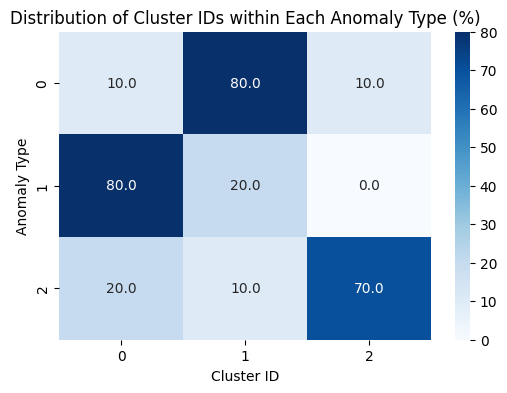

In [61]:
# Check how clusters align with true anomaly types
pca_merged = pd.merge(df_pca_kmeans, y_cat, on="user", how="inner")

# View alignment
ct = pd.crosstab(pca_merged["anomtype"], pca_merged["cluster"], normalize="index") * 100
plt.figure(figsize=(6,4))
sns.heatmap(ct, annot=True, cmap="Blues", fmt=".1f")
plt.title("Distribution of Cluster IDs within Each Anomaly Type (%)")
plt.ylabel("Anomaly Type")
plt.xlabel("Cluster ID")
plt.show()

We found that applying PCA to reduce our data does improve our performance.  
We thus choose PCA + KMeans as our final model, and we also save the cluster-to-anomaly type mapping for use later in our predictions.

### Preparing final classification model

In [62]:
# Create dynamic mapping of cluster IDs to anomaly types
conf_matrix = pd.crosstab(pca_merged["cluster"], pca_merged["anomtype"])
cluster_to_anomtype = conf_matrix.idxmax(axis=1).to_dict()
print("Cluster to Anomaly Type Mapping:", cluster_to_anomtype)

Cluster to Anomaly Type Mapping: {0: 1, 1: 0, 2: 2}


## Making predictions on second batch

### Data cleaning

In [63]:
# Checking what the test batch looks like again

XX

,user,item,rating
0,1800,594,2
1,1800,371,4
2,1800,365,4
3,1800,362,4
4,1800,359,4
...,...,...,...
286896,2699,295,1
286897,2699,280,3
286898,2699,542,0
286899,2699,870,0


### Feature Engineering

In [64]:
# Prepare dataframe for predictions

XX_df = engineer_features(XX)
XX_df.columns = XX_df.columns.astype(str)

display(XX_df.head())
print(XX_df.shape)

,0,1,2,3,4,5,6,7,8,9,...,std_rating,count_dislike,count_neutral,count_like,total_interactions,like_ratio,dislike_ratio,neutral_ratio,weighted_score,rating_kurtosis
user,,,,,,,,,,,,,,,,,,,,,
1800,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,-1.0,...,1.102741,81,81,103,265,0.388679,0.305660,0.305660,33.0,-0.722228
1801,-1.0,-1.0,2.0,-1.0,5.0,-1.0,-1.0,-1.0,-1.0,5.0,...,0.991834,30,34,278,342,0.812865,0.087719,0.099415,372.0,1.442189
1802,5.0,-1.0,-1.0,-1.0,4.0,-1.0,-1.0,5.0,-1.0,-1.0,...,0.960452,75,149,202,426,0.474178,0.176056,0.349765,190.5,-0.048216
1803,-1.0,-1.0,4.0,-1.0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.731260,5,22,206,233,0.884120,0.021459,0.094421,301.5,1.518336
1804,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.619327,12,157,93,262,0.354962,0.045802,0.599237,121.5,0.592298


(900, 1012)


### Supervised learning prediction (StackingRegressor)

In [65]:
# Generate predictions using the trained StackingRegressor model (XGBR, MLP --> Ridge)

XX_df_reg = scaler_full.transform(XX_df)

yy_label_pred = stack.predict(XX_df_reg)
print(yy_label_pred.shape)

(900,)


c:\Users\Ben\anaconda3\envs\cs421\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


### Unsupervised learning prediction (PCA+ KMeans)

In [66]:
# Prepare data for PCA + KMeans

# Retrieve only the generated features
XX_pca_features = XX_df[[
    "mean_rating",
    "median_rating",
    "std_rating",
    "count_dislike",
    "count_neutral",
    "count_like",
    "total_interactions",
    "like_ratio",
    "dislike_ratio",
    "neutral_ratio",
    "weighted_score",
    "rating_kurtosis"
]]

# Standardise using training scaler (turns into a numpy array)
XX_pca_scaled = scaler_kmeans.transform(XX_pca_features)

# Transform using trained PCA model
XX_pca_transformed = pca.transform(XX_pca_scaled)

# Predict using trained PCA-based KMeans
XX_clusters = pca_kmeans.predict(XX_pca_transformed)

In [67]:
# Map cluster IDs to anomaly types
yy_label_cluster = np.array([cluster_to_anomtype[c] for c in XX_clusters])

### Saving the result

In [68]:
# Combine dataframe with predicted results

result_df = XX_df.reset_index()
result_df = result_df[["user"]]
result_df["label"] = yy_label_pred # from XGBRegressor
result_df["anomtype"] = yy_label_cluster # mapped from clusters
display(result_df.head(10))

,user,label,anomtype
0,1800,0.354476,0
1,1801,0.509547,2
2,1802,0.616988,1
3,1803,0.290726,2
4,1804,0.600762,1
5,1805,0.726883,1
6,1806,0.912401,0
7,1807,0.802184,2
8,1808,0.564170,1
9,1809,0.225395,1


In [69]:
# Clean up label predictions
# We normalise label column as some predictions are <0 or >1

result_df["label"] = result_df["label"].clip(lower=0, upper=1)
result_df

,user,label,anomtype
0,1800,0.354476,0
1,1801,0.509547,2
2,1802,0.616988,1
3,1803,0.290726,2
4,1804,0.600762,1
...,...,...,...
895,2695,0.648988,2
896,2696,0.681259,1
897,2697,0.175893,1
898,2698,0.663562,2


In [70]:
# Save as csv

result_df.to_csv('third_batch_output.csv',index=False)
print("Result successfully saved")

Result successfully saved
